# PCA for the edgecase dataset

Using **principal component analysis** (PCA) will help us understand how closely and in what manner the different features are related to each other and to the output value (collision). We can often find that some features have very high impact on the output variable and some have negligible effect. This can reveal dependencies of vehicle parameters on an output which may not be obvious looking at thousands of mixed datapoints.

PCA also helps you reduce the dimensionality of the original dataset. Hence making the training challenge less complex. However, we shall not apply the reduced dimensionality to our training dataset in this project since we wish to capture all possible system dynamics for an accurate prediction


### Workflow

To implement population segmentation, you'll go through a number of steps:
* Data loading and exploration
* Data cleaning and pre-processing (if necessary) 
* Dimensionality reduction with PCA
* Component makeup and relational analysis
* Plotting component data using covariance PCA

---

First, import the relevant libraries into this SageMaker notebook. 

In [2]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import sagemaker

In [26]:
import boto3

## Loading the Data from Amazon S3

This particular dataset is already in the local notebook directory; you can upload the data on S3 and download if preferred. 

In [4]:
# create a dataframe
main_df = pd.read_csv('data/edgecase_dataset.csv', header=0) 
main_df.head()

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision,dist_to_col
0,2550.0,2.0,140.0,0.2,0.4,140.0,0.030,1.5,6,3.5,30,0.07,14,0.07,60,1.0,-112.229470
1,2550.0,2.4,60.0,0.4,0.7,140.0,0.015,2.5,5,4.5,15,0.10,15,0.10,60,1.0,-149.581660
2,1200.0,2.4,60.0,0.4,0.7,120.0,0.008,4.0,3,6.0,12,0.14,8,0.14,10,1.0,-66.651648
3,3000.0,2.8,100.0,0.2,1.0,120.0,0.030,3.0,5,4.5,23,0.10,11,0.10,60,1.0,-30.155521
4,2100.0,2.8,40.0,0.1,0.4,100.0,0.015,3.0,5,4.5,23,0.10,11,0.10,40,1.0,-50.162968


In [12]:
main_df.describe()

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision,dist_to_col
count,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000
mean,2100.018518,2.400000,85.000720,0.233337,0.699997,110.000617,0.017667,2.800009,4.799984,4.400017,21.999825,0.102000,12.399981,0.102000,36.666118,0.670531,-35.116654
std,636.405924,0.326597,38.405966,0.124724,0.244950,22.360979,0.009177,0.812409,0.979808,0.916525,7.456605,0.022271,2.576859,0.022271,20.548297,0.470023,71.841036
min,1200.000000,2.000000,40.000000,0.100000,0.400000,80.000000,0.008000,1.500000,3.000000,3.500000,12.000000,0.070000,8.000000,0.070000,10.000000,0.000000,-306.081340
25%,1650.000000,2.000000,60.000000,0.100000,0.400000,100.000000,0.008000,2.500000,5.000000,3.500000,15.000000,0.100000,11.000000,0.100000,10.000000,0.000000,-77.855403
50%,2100.000000,2.400000,100.000000,0.200000,0.700000,120.000000,0.015000,3.000000,5.000000,4.500000,23.000000,0.100000,14.000000,0.100000,40.000000,1.000000,-28.427832
75%,2550.000000,2.800000,130.000000,0.400000,1.000000,140.000000,0.030000,3.000000,5.000000,4.500000,30.000000,0.100000,14.000000,0.100000,60.000000,1.000000,14.440267
max,3000.000000,2.800000,140.000000,0.400000,1.000000,140.000000,0.030000,4.000000,6.000000,6.000000,30.000000,0.140000,15.000000,0.140000,60.000000,1.000000,114.444110


## Exploratory Data Analysis (EDA)

**Note**: The dataset has been already cleaned and analysed in the notebook 'edgecase_data_processing.ipynb'. Hence, we shall not do the same here, expect a few quick pyplot plots.

The idea is to check the distruibution of each feature in the dataset. 

In [6]:
# features
features_list = main_df.columns.values
print('Features: \n', features_list)

Features: 
 ['body_mass' 'cogx' 'obj_dist' 'react_time' 'road_mu' 'speed' 'tire_rr'
 'pedal.ratio' 'boo.ampli' 'mc.area' 'pf.area' 'pf.rbrake' 'pr.area'
 'pr.rbrake' 'update_rate' 'collision' 'dist_to_col']


## Visualizing the Data

The below cell displays **histograms**, which show the distribution of data points over discrete feature ranges. The x-axis represents the different bins; each bin is defined by a specific range of values that a feature can take, say between the values 0-5 and 5-10, and so on. The y-axis is the frequency of occurrence or the number of county data points that fall into each bin. 

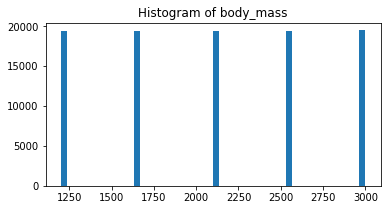

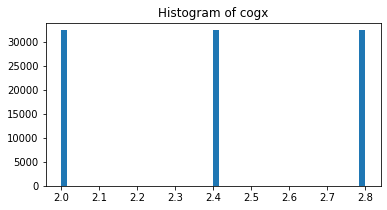

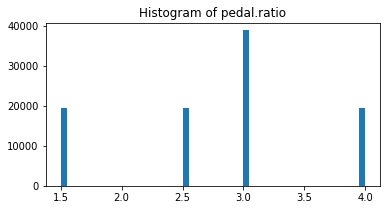

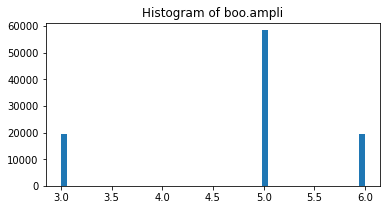

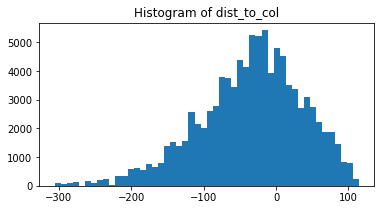

In [8]:
# transportation (to work)
feature_list = ['body_mass', 'cogx', 'pedal.ratio', 'boo.ampli', 'dist_to_col']
n_bins = 50 # can decrease to get a wider bin (or vice versa)

for column_name in feature_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(main_df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

### Normalize the data

You need to standardize the scale of the numerical columns in order to consistently compare the values of different features. You can use a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to transform the numerical values so that they all fall between 0 and 1.

In [127]:
# scale numerical features into a normalized range, 0-1

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
# store them in this dataframe
df_scaled=pd.DataFrame(scaler.fit_transform(main_df.astype(float)))

# get same features and State-County indices
df_scaled.columns=main_df.columns
df_scaled.index=main_df.index

df_scaled.head()

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision,dist_to_col
0,0.75,0.0,1.0,0.333333,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.000000,0.857143,0.000000,1.0,1.0,0.460975
1,0.75,0.5,0.2,1.000000,0.5,1.000000,0.318182,0.4,0.666667,0.4,0.166667,0.428571,1.000000,0.428571,1.0,1.0,0.372153
2,0.00,0.5,0.2,1.000000,0.5,0.666667,0.000000,1.0,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.0,1.0,0.569358
3,1.00,1.0,0.6,0.333333,1.0,0.666667,1.000000,0.6,0.666667,0.4,0.611111,0.428571,0.428571,0.428571,1.0,1.0,0.656145
4,0.50,1.0,0.0,0.000000,0.0,0.333333,0.318182,0.6,0.666667,0.4,0.611111,0.428571,0.428571,0.428571,0.6,1.0,0.608568


In [128]:
df_scaled.describe()

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision,dist_to_col
count,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000,97202.000000
mean,0.500010,0.500000,0.450007,0.444456,0.499995,0.500010,0.439391,0.520004,0.599995,0.360007,0.555546,0.457148,0.628569,0.457148,0.533322,0.670531,0.644348
std,0.353559,0.408246,0.384060,0.415745,0.408249,0.372683,0.417147,0.324964,0.326603,0.366610,0.414256,0.318161,0.368123,0.318161,0.410966,0.470023,0.170836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000000,0.200000,0.000000,0.000000,0.333333,0.000000,0.400000,0.666667,0.000000,0.166667,0.428571,0.428571,0.428571,0.000000,0.000000,0.542716
50%,0.500000,0.500000,0.600000,0.333333,0.500000,0.666667,0.318182,0.600000,0.666667,0.400000,0.611111,0.428571,0.857143,0.428571,0.600000,1.000000,0.660254
75%,0.750000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.666667,0.400000,1.000000,0.428571,0.857143,0.428571,1.000000,1.000000,0.762193
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
df_scaled = df_scaled.iloc[:,:16]

In [133]:
df_scaled

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision
0,0.75,0.0,1.0,0.333333,0.0,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.000000,0.857143,0.000000,1.0,1.0
1,0.75,0.5,0.2,1.000000,0.5,1.000000,0.318182,0.4,0.666667,0.4,0.166667,0.428571,1.000000,0.428571,1.0,1.0
2,0.00,0.5,0.2,1.000000,0.5,0.666667,0.000000,1.0,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.0,1.0
3,1.00,1.0,0.6,0.333333,1.0,0.666667,1.000000,0.6,0.666667,0.4,0.611111,0.428571,0.428571,0.428571,1.0,1.0
4,0.50,1.0,0.0,0.000000,0.0,0.333333,0.318182,0.6,0.666667,0.4,0.611111,0.428571,0.428571,0.428571,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97197,0.00,0.5,0.6,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,1.000000,0.000000,0.857143,0.000000,0.6,0.0
97198,0.75,0.5,0.0,0.000000,0.0,0.333333,1.000000,0.4,0.666667,0.4,0.166667,0.428571,1.000000,0.428571,0.6,1.0
97199,1.00,0.5,0.2,0.333333,1.0,0.666667,1.000000,0.4,0.666667,0.4,0.166667,0.428571,1.000000,0.428571,0.0,1.0
97200,0.50,0.5,0.6,1.000000,0.5,0.000000,1.000000,1.0,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.6,0.0


---

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data.

### Roles and Buckets

> To create a model, you'll first need to specify an IAM role, and to save the model attributes, you'll need to store them in an S3 bucket.

In [17]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::286722933665:role/service-role/AmazonSageMaker-ExecutionRole-20210616T212656


In [18]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-286722933665



## Define a PCA Model

To create a PCA model, I'll use the built-in SageMaker resource. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

In [22]:
# define location to store model artifacts
prefix = 'capstone_edgecase/pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix) # location on S3 where model attributes will be saved

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-286722933665/capstone_edgecase/pca/


In [131]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=15

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c5.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format that is the required format for the training input data.

In [132]:
# convert df to np array
train_data_np = df_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

## Train the model

Call the fit function on the PCA model, passing in our formatted, training data. 
Note that it takes the longest to launch the specified training instance; the fitting itself doesn't take much time.

In [134]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-29 21:35:34 Starting - Starting the training job...
2021-06-29 21:35:36 Starting - Launching requested ML instancesProfilerReport-1625002534: InProgress
...
2021-06-29 21:36:34 Starting - Preparing the instances for training.........
2021-06-29 21:38:05 Downloading - Downloading input data
2021-06-29 21:38:05 Training - Downloading the training image...
2021-06-29 21:38:33 Uploading - Uploading generated training model
2021-06-29 21:38:33 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/29/2021 21:38:23 INFO 140446884374336] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[06/29/2021 21:38:23 INFO 140446884374336] Merg

Training seconds: 34
Billable seconds: 34
CPU times: user 420 ms, sys: 17.5 ms, total: 438 ms
Wall time: 3min 11s


## Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.

### Unzip the Model Details

Now that the training job is complete, you can find the job under **Jobs** in the **Training**  subsection  in the Amazon SageMaker console. You can find the job name listed in the training jobs. Use that job name in the following code to specify which model to examine.

Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

In [135]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-06-29-21-35-34-384'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

capstone_edgecase/pca/pca-2021-06-29-21-35-34-384/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

In [31]:
#pip install mxnet

     |████████████████████████████████| 46.9 MB 149 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import mxnet as mx

In [136]:
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[1.90734863e-06 1.72619224e-01 1.99320164e+01 5.78516960e+01
 6.83957672e+01 9.04807129e+01 1.10820320e+02 1.17622566e+02
 1.27069252e+02 1.27279236e+02 1.28126602e+02 1.29612549e+02
 1.30052414e+02 1.75652740e+02 2.66771210e+02]
<NDArray 15 @cpu(0)>, 'v': 
[[-4.71118435e-17  2.27637747e-06  1.19124977e-02 -1.67710990e-01
  -1.76289469e-01 -6.42172247e-02 -9.54975247e-01 -6.64392933e-02
   2.10624058e-02 -4.55225882e-06  9.50269343e-04  2.87419651e-03
  -1.81195582e-03 -1.40171260e-01 -5.77703025e-03]
 [-2.40181142e-16  7.29309662e-08 -7.02785677e-04  9.09921527e-03
   9.05585010e-03  2.51429784e-03 -2.52196798e-03 -3.73205752e-03
   1.25261575e-01  9.91922140e-01 -1.66769559e-03 -1.82228407e-03
   9.71131492e-04  1.41714420e-02  4.90446750e-04]
 [ 1.00093314e-16 -5.15811962e-06 -2.91634239e-02  3.90062392e-01
   3.96005630e-01  1.20016523e-01 -1.76120594e-01 -6.42898381e-01
  -1.35515511e-01  8.45969262e-05 -6.56965468e-03 -1.65587906e-02
   9.88633092e-03  4.60823327e-01  1.73

## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.


In [137]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

## Data Variance

Our current PCA model creates 15 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 16 features captured 100% of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [138]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 15-n

# print a selection of s
print(s.iloc[start_idx:, :])

             0
10  128.126602
11  129.612549
12  130.052414
13  175.652740
14  266.771210


### Calculate the explained variance

In creating new training data, we want to choose the top n principal components that account for at least 80% data variance. 

The `explained_variance` method takes in the entire array `s` and a number of top principal components to consider. Then return the approximate, explained variance for those top n components. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> Using this function, you should be able to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

In [36]:
# Calculate the explained variance for the top n principal components
# you can assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


### Test Cell

Test out your own code by seeing how it responds to different inputs; does it return a reasonable value for the single, top component? What about for the top 5 components?

In [154]:
# test cell
n_top_components = 7 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.81196755


As an example, you should see that the top principal component accounts for about 32% of our data variance!

Below, let's take a look at our original features and use that as a reference.

In [143]:
# features
features_list = df_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['body_mass' 'cogx' 'obj_dist' 'react_time' 'road_mu' 'speed' 'tire_rr'
 'pedal.ratio' 'boo.ampli' 'mc.area' 'pf.area' 'pf.rbrake' 'pr.area'
 'pr.rbrake' 'update_rate' 'collision']


## Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [44]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in df_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


## 1st Principal Component plot

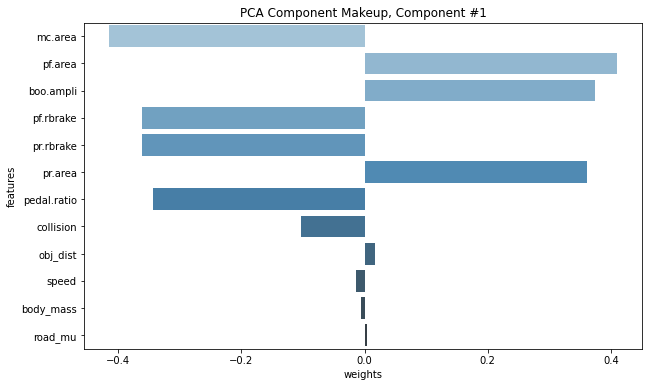

In [161]:
# display makeup of first component
num=1
display_component(v, df_scaled.columns.values, component_num=num, n_weights=12)

<b> Key Observation: Principal component 1 </b>

*Note: The features that contribute to this component as shown on the y-axis*

- The first principal component shows the strong relationship between all the brake parameters. Note that negative-positive weight relations mean, if the former decreases the latter increases in value and vice-versa for same-sign weighted features in that principal component. **For example, the feature dataset in our case suggests that as Master cylinder area (mc.area) of the brake system increases, the Piston areas (pf.area/pr.area) decrease. This reveals a design decision for the Brake system for the vehicle(s) in the dataset involved!**

## 2nd Principal Component plot

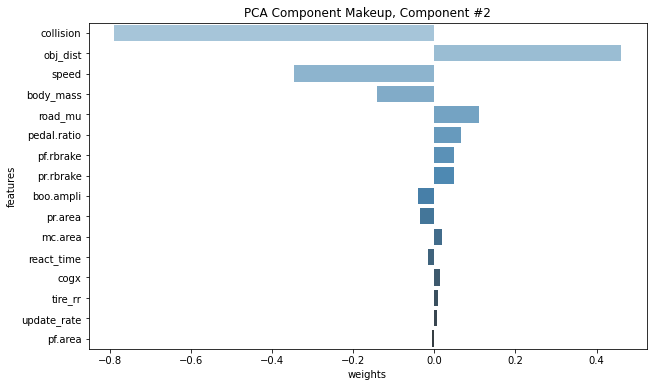

In [163]:
# display makeup of second component
num=2
display_component(v, df_scaled.columns.values, component_num=num, n_weights=16)

<b> Key Observation: Principal component 2 </b>

*Note: The features that contribute to this component as shown on the y-axis*

- The second component shows the relation between the output collision and all the features

- It is clear that the **obj_dist** distance between the vehicle and the object has lot to do whether a collision will occur or not - as the obj_dist increases the probability of collision decreases which is visible by the opposite weight signs. Also, we can see if the **speed** decreases, the probability of collision also decreases

- **Body mass** is the next vehicle parameters which has high influence on collision probability. **Road friction coefficient** is an environment parameter after 'obj_dist' which has a strong correlation with collision 

- Out of all the Brake system parameters, **Pedal.ratio** has the highest influence on collision probability. Interesting to note that **front piston area** has a much lesser effect compared to **rear piston area**

- **Brake reaction time** (0.1s, 0.2s, 0.4s) and the **centre of gravity** of the vehicle have very low effect

- Tire **rolling resistance** and the **update rate of the sensor** have negligible effect on the collision probability

## PCA using covariance matrix

Import libraries

In [ ]:
import pandas as pd
import numpy as np

In [3]:
# create a dataframe
main_df = pd.read_csv('data/edgecase_dataset.csv', header=0) 
main_df.head()

,body_mass,cogx,obj_dist,react_time,road_mu,speed,tire_rr,pedal.ratio,boo.ampli,mc.area,pf.area,pf.rbrake,pr.area,pr.rbrake,update_rate,collision,dist_to_col
0,2550.0,2.0,140.0,0.2,0.4,140.0,0.030,1.5,6,3.5,30,0.07,14,0.07,60,1.0,-112.229470
1,2550.0,2.4,60.0,0.4,0.7,140.0,0.015,2.5,5,4.5,15,0.10,15,0.10,60,1.0,-149.581660
2,1200.0,2.4,60.0,0.4,0.7,120.0,0.008,4.0,3,6.0,12,0.14,8,0.14,10,1.0,-66.651648
3,3000.0,2.8,100.0,0.2,1.0,120.0,0.030,3.0,5,4.5,23,0.10,11,0.10,60,1.0,-30.155521
4,2100.0,2.8,40.0,0.1,0.4,100.0,0.015,3.0,5,4.5,23,0.10,11,0.10,40,1.0,-50.162968


In [13]:
from sklearn.preprocessing import StandardScaler

In [28]:
sc = StandardScaler()
transformed = sc.fit_transform(X)

In [44]:
# source: https://www.askpython.com/python/examples/principal-component-analysis
def PCA(X , num_components):
    
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
    
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
    
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
    
    return X_reduced

In [85]:
X = main_df.iloc[:,:16]
y = main_df['collision']

In [86]:
y2 = main_df['dist_to_col']

In [87]:
X = sc.fit_transform(X)

In [88]:
#Applying it to PCA function
mat_reduced = PCA(X , 15)

#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15'])

#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(y)] , axis = 1)

### Plotting reduced PCA dimension data

In [ ]:
import seaborn as sb

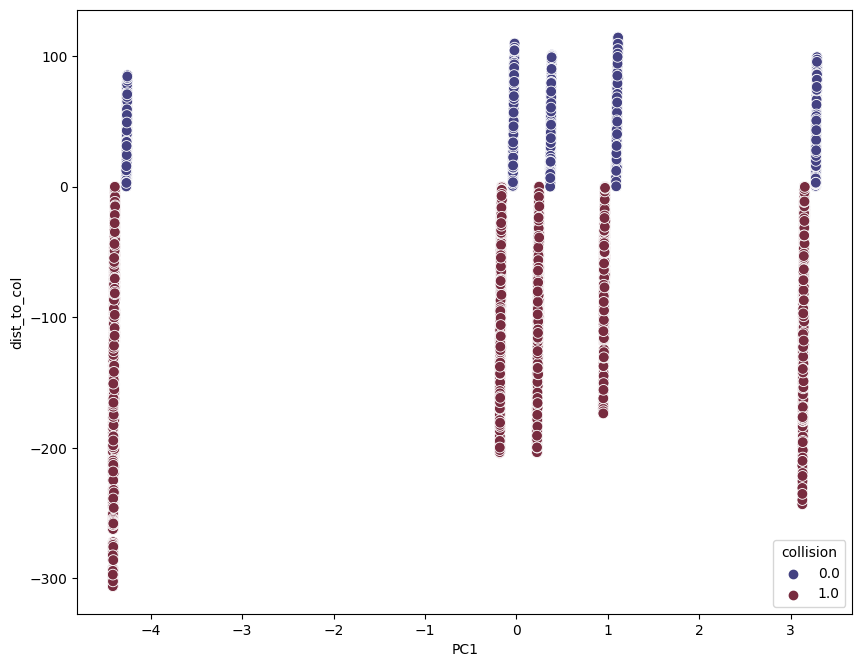

In [89]:
plt.figure(figsize=(10,8), dpi=100)
sb.scatterplot(data = principal_df , x = 'PC1', y = y2 ,  hue = y , s = 60 , palette= 'icefire')
plt.show()

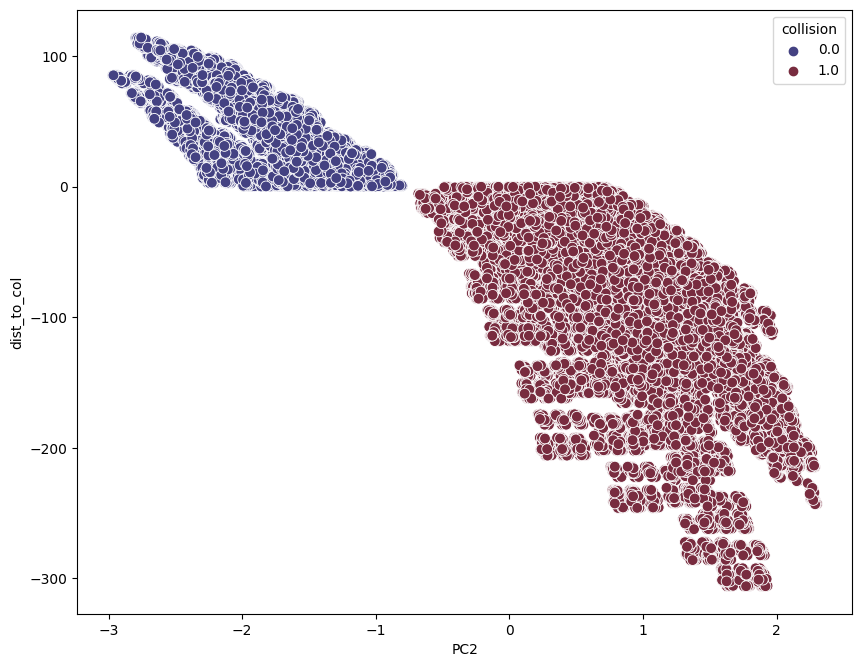

In [92]:
plt.figure(figsize=(10,8), dpi=100)
sb.scatterplot(data = principal_df , x = 'PC2', y = y2 ,  hue = y , s = 60 , palette= 'icefire')
plt.show()

#### Plotting how original data looked with original features

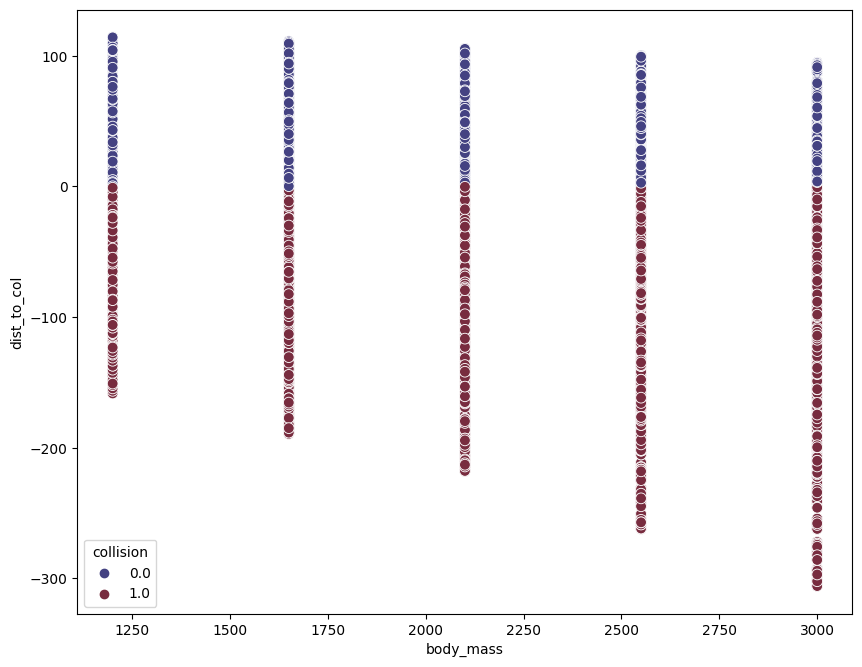

In [83]:
plt.figure(figsize=(10,8), dpi=100)
sb.scatterplot(data = main_df , x = 'body_mass',y = y2 ,  hue = y , s = 60 , palette= 'icefire')
plt.show()

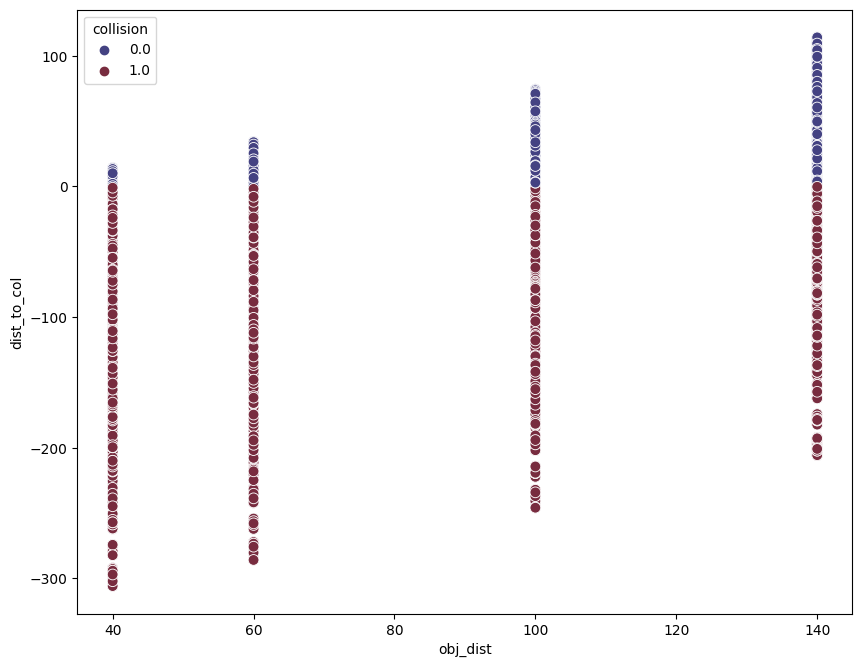

In [84]:
plt.figure(figsize=(10,8), dpi=100)
sb.scatterplot(data = main_df , x = 'obj_dist',y = y2 ,  hue = y , s = 60 , palette= 'icefire')
plt.show()

## Conclusion

- PCA shows how strongly different variables are related to each other 
    - By including the output variable (in this case: collision) as part of the PCA training, we can see the amount and type of effect the features have on the vehicle's collision with the traffic object
    - The values of weights range between -1 and +1. Positive indicates that when one variable increases, the other increases as well, while negative indicates vice versa. And the length of the bar indicates the strength of correlation
    - From the latter plots we can see how different principal components values are compared with the original features 
- It helps in reducing the dimensionality of the training dataset which will be very useful when the number of features will increase

---